In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

from numba import njit

# Voter model with mutation

In [31]:
@njit
def init_grid(K):
    '''Initialises a K by K grid with numbers drawn randomly from (0, 1)'''
    return np.random.rand(K, K)

In [32]:
@njit
def get_8_neighbors(i, j, K):
    '''Finds all 8 neighbors of a site in a K by K grid'''
    neighbors = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            # Skip the current site
            if di == 0 and dj == 0:
                continue
            # Apply periodic boundary conditions
            neighbor_i = int((i + di) % K)  
            neighbor_j = int((j + dj) % K)
            neighbors.append((neighbor_i, neighbor_j))
    return neighbors

@njit
def get_4_neighbors(i, j, K):
    '''Finds upper, lower, left and righ neighbor of a site in a K by K grid'''
    neighbors = []
    # Up, down, right, left
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    for di, dj in directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % K)
        neighbor_j = int((j + dj) % K)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [33]:
import random

@njit
def update_grid(grid, alpha, delta):
    ''' Updates the grid according to rules of coter model with mutation
    Inputs:
    grid (numpy array): Grid representing ecosystem
    alpha (float): Value of alpha parameter
    delta (float): Value of delta parameter
    
    Returns:
    grid (numpy array): Grid after each site has been updated
    '''
    # Extract height and width from the grid
    height, width = grid.shape
    
    for i in range(height):
        for j in range(width):
            neighbors = get_4_neighbors(i, j, L)
            # New species migrates into grid at rate alpha
            if random.random() < alpha:
                grid[i, j] = random.random()
            # Set species in cell to that in one of its 4 neighbors with equal probability
            if random.random() < delta:
                neighbor_idx = np.random.choice(len(neighbors))
                new_type = grid[neighbors[neighbor_idx]]
                grid[i, j] = new_type
    return grid

In [34]:
@njit
def voter_model(grid_0, alpha, delta, n_iters):
    '''Run experiment with the voter model
    Inputs:
    grid_0 (numpy array): Initial grid
    alpha (float): Value of alpha parameter
    delta (float): Value of delta parameter
    n_iters (int): Number of times that the entire grid is updated
    
    Returns:
    cur_grid (numpy array): Grid after n_iter iterations
    num_species (list): Contains amount of different species at each tenth iteration
    '''
    # Create list to store number of unique species
    num_species = []
    cur_grid = np.copy(grid_0)
    
    # Update grid n_iter times
    for i in range(n_iters):
        cur_grid = update_grid(cur_grid, alpha, delta)
        # Save amount of species every tenth iteration
        if i % 10 == 0:
            num_species.append(len(np.unique(cur_grid)))
    return cur_grid, num_species

In [35]:
# Define parameters as in paper
alpha = 10e-5
delta = 0.2
L = 1 / np.sqrt(alpha)
K = int(L**(4/3))

grid_0 = init_grid(K)
n_iters = 1000
grid, num_species = voter_model(grid_0, alpha, delta, n_iters)


Text(0.5, 1.0, 'Grid after 1000 iterations')

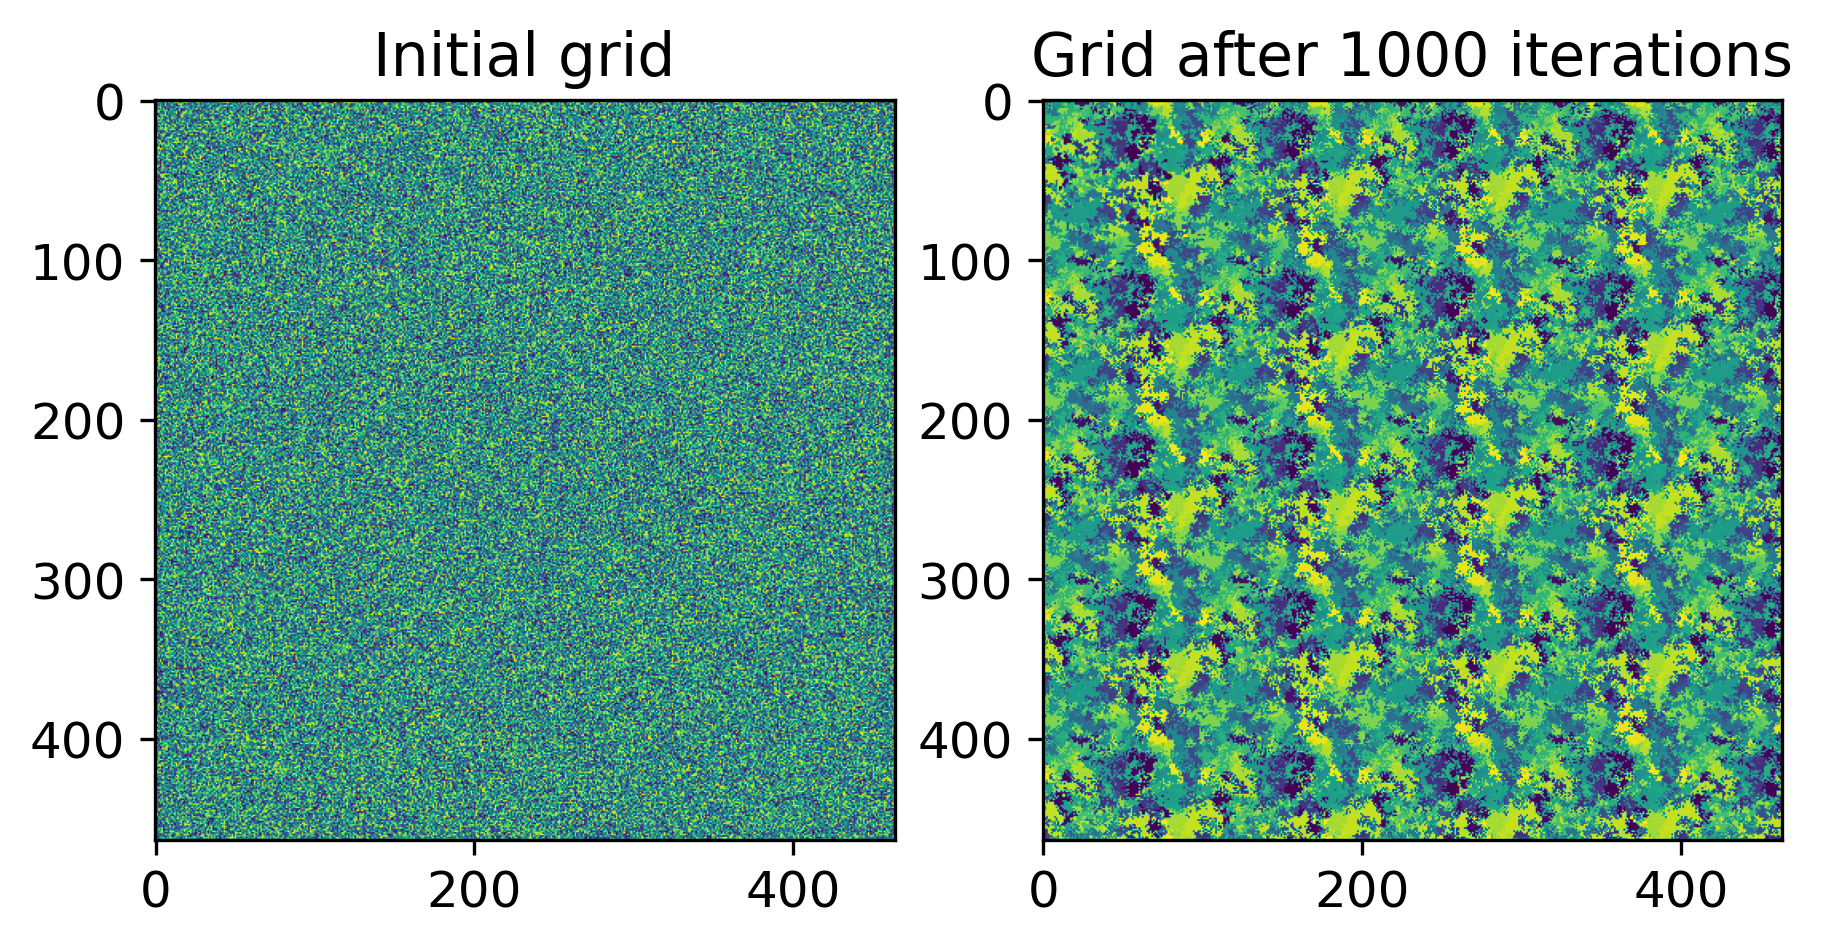

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

ax1.imshow(grid_0)
ax1.set_title('Initial grid')

ax2.imshow(grid)
ax2.set_title(f'Grid after {n_iters} iterations')

Text(0.5, 0, 'Number of iterations (x10)')

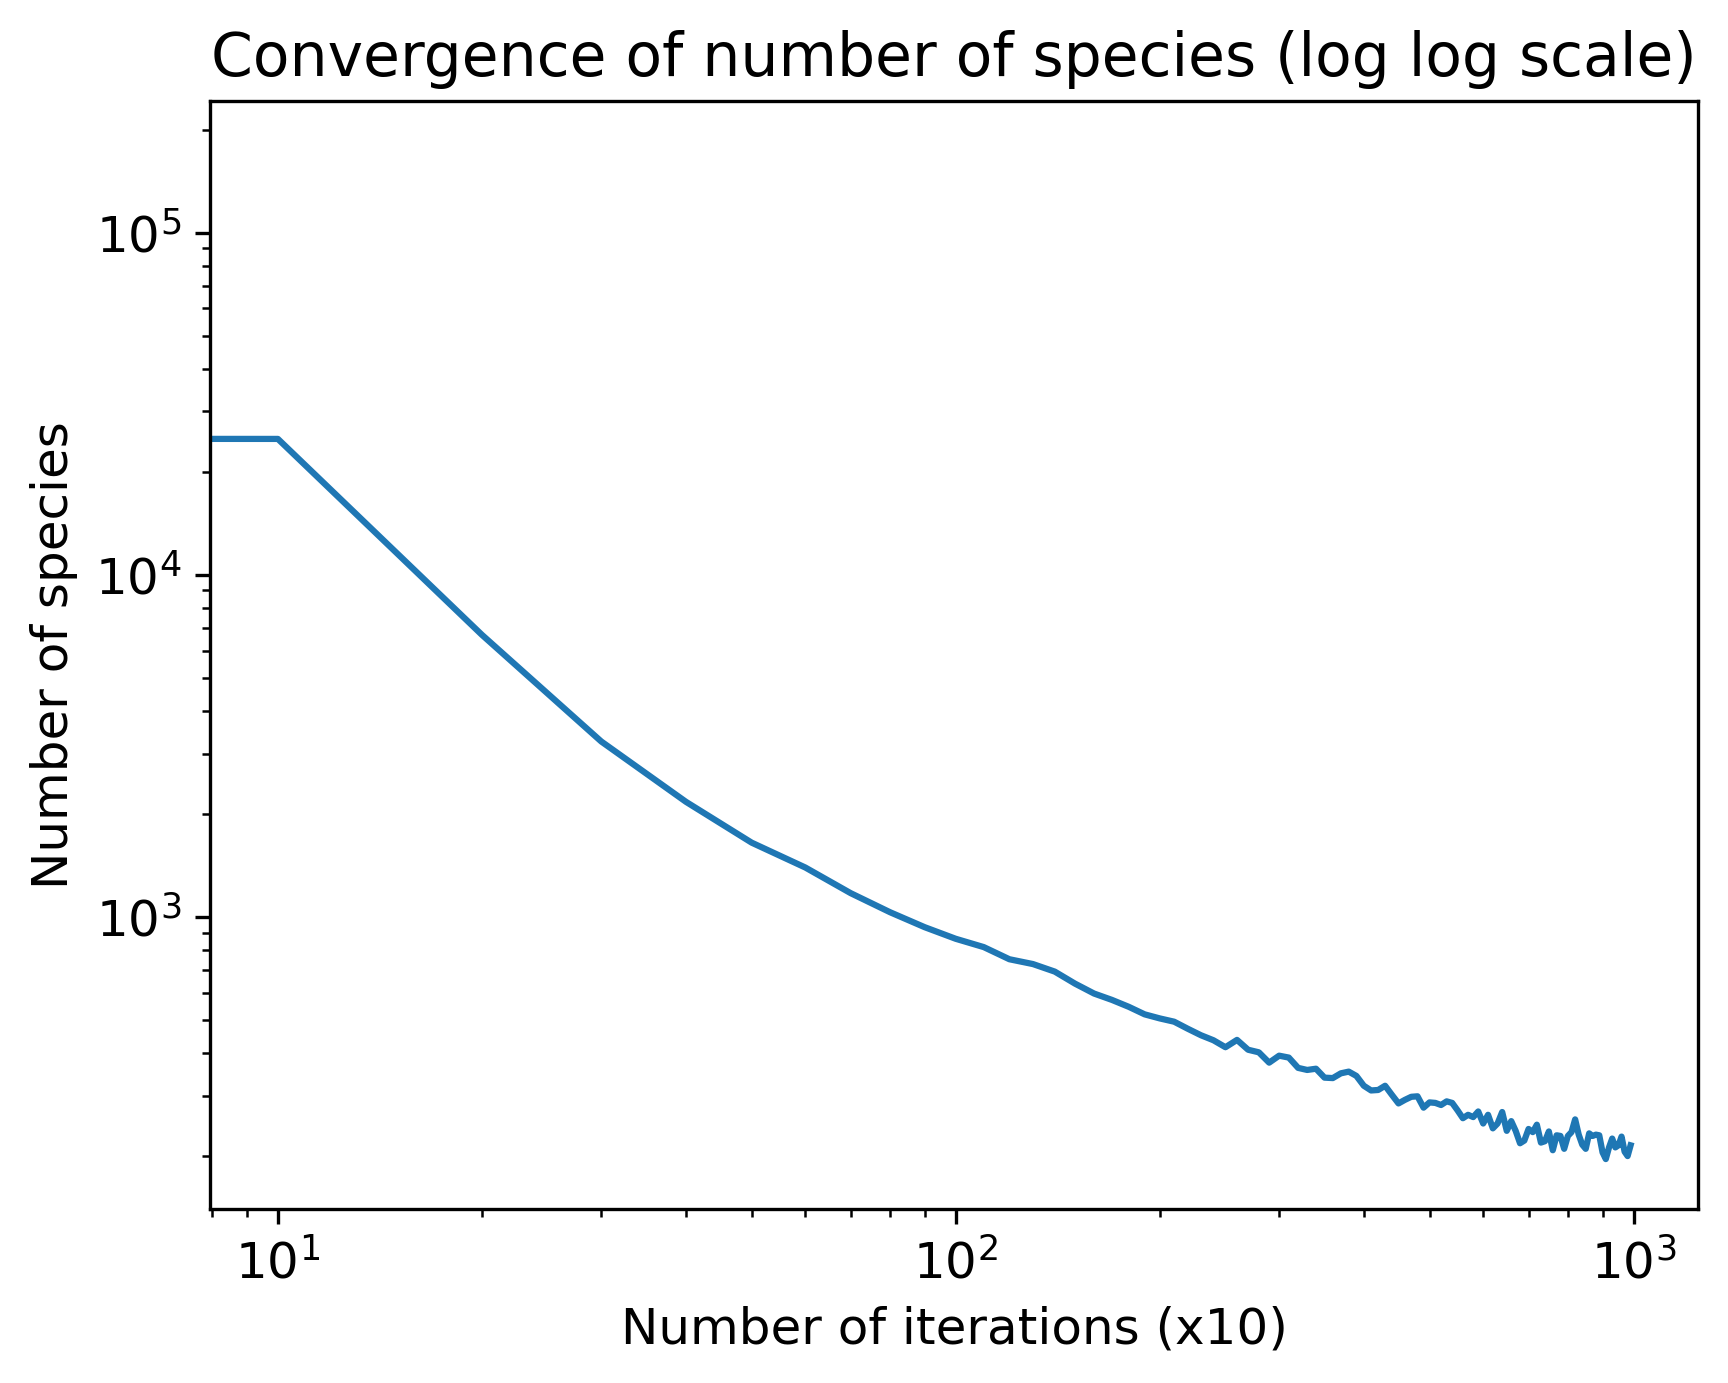

In [37]:
plt.loglog(10 * np.arange(len(num_species)), num_species)
plt.title('Convergence of number of species (log log scale)')
plt.ylabel('Number of species')
plt.xlabel('Number of iterations (x10)')

In [48]:
center = 49

areas = []
species = []

for i in range(49):
    species.append(len(np.unique(grid[center - i:center + i+1, center - i:center + i+1])))
    areas.append((i+1)**2)

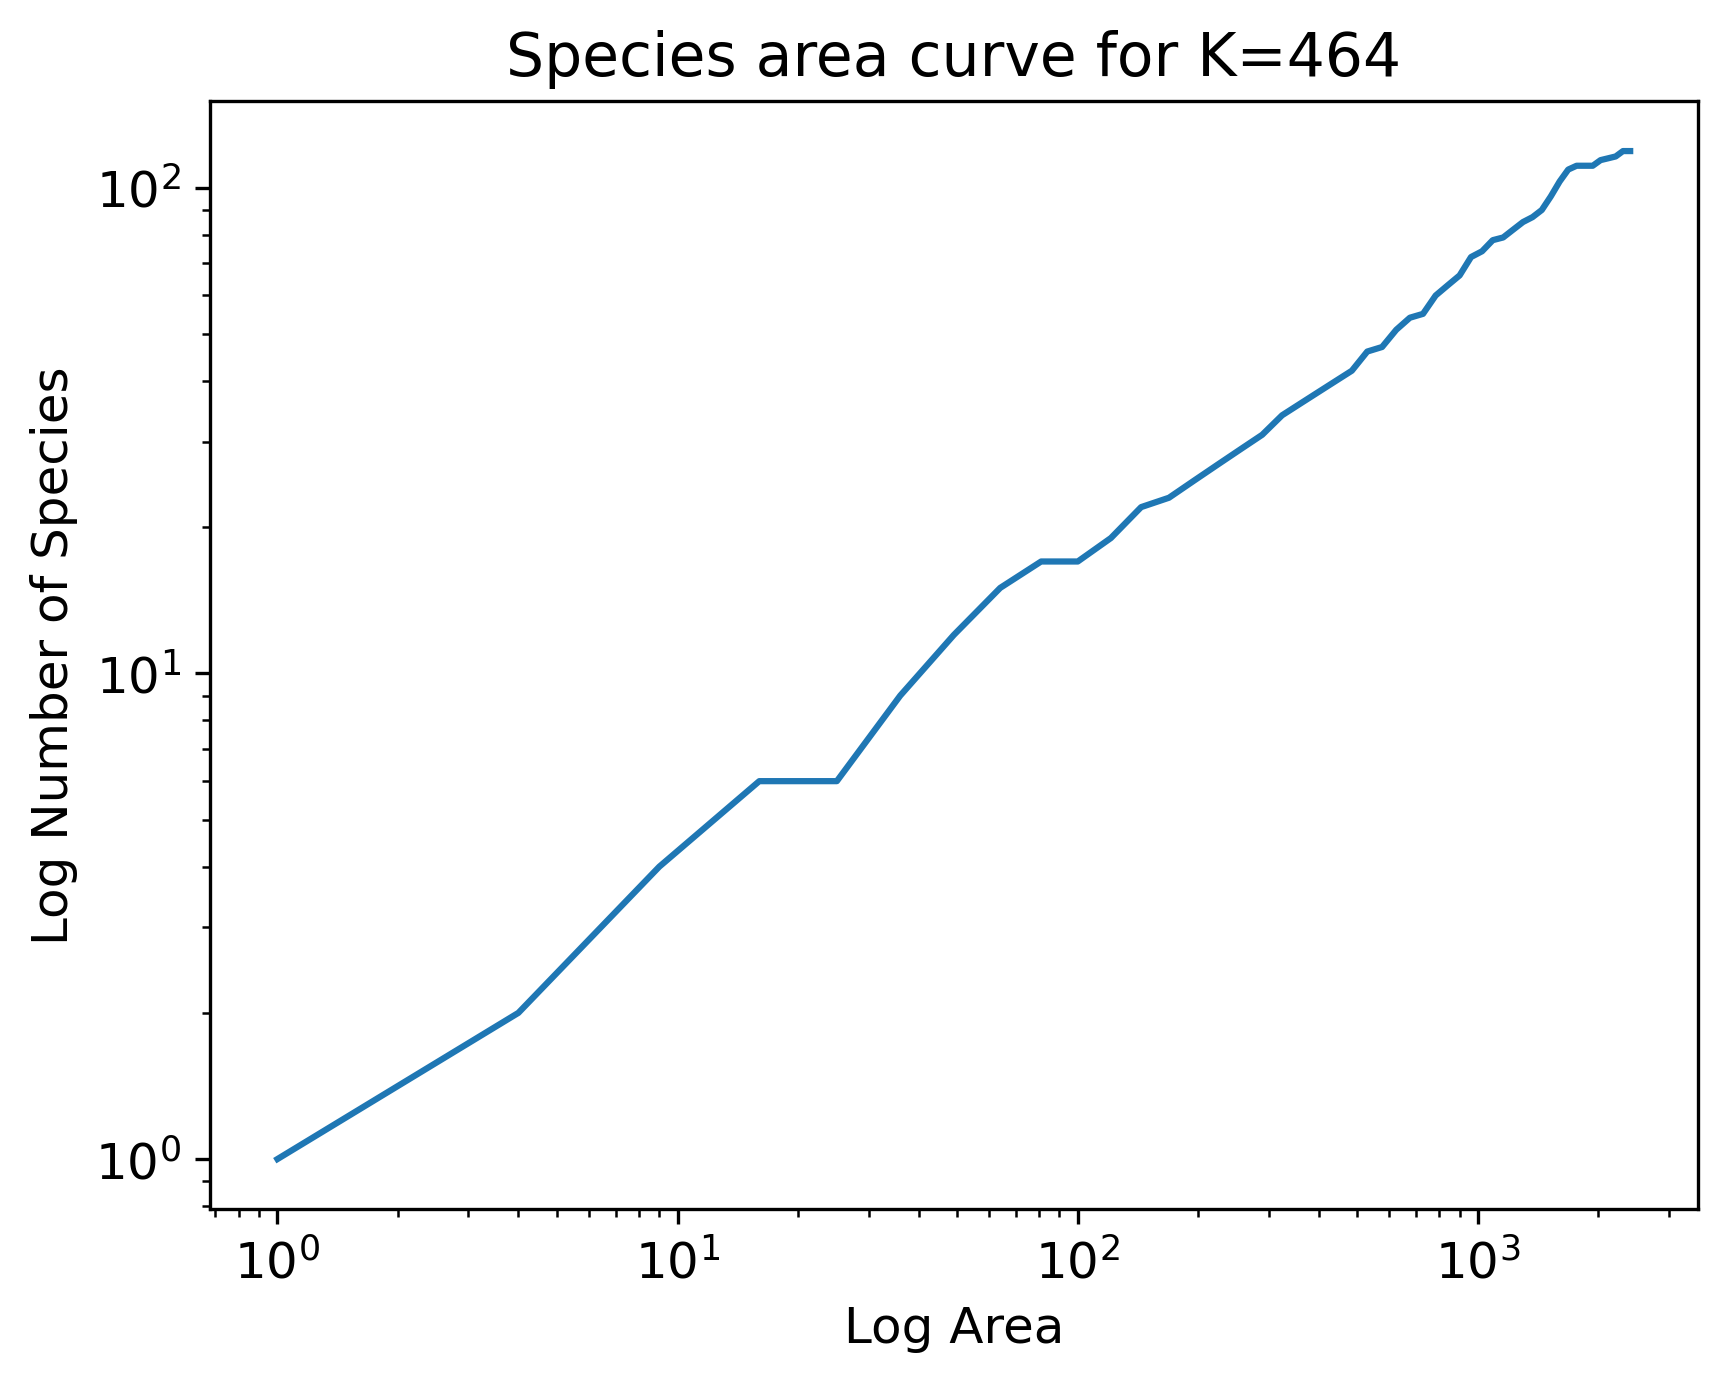

In [53]:
plt.loglog(areas, species)
plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Species area curve for K={K}')
plt.show()